In [1]:
import os
import scipy.misc
import numpy as np

from forward_model import DCGAN
from utils import pp, visualize, to_json, show_all_variables

import tensorflow as tf

from glob import glob
from ops import *
from utils import *

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# flags
flags = tf.app.flags
flags.DEFINE_integer("epoch", 25, "Epoch to train [25]")
flags.DEFINE_float("learning_rate", 0.0002, "Learning rate of for adam [0.0002]")
flags.DEFINE_float("beta1", 0.5, "Momentum term of adam [0.5]")
flags.DEFINE_integer("train_size", np.inf, "The size of train images [np.inf]")
flags.DEFINE_integer("batch_size", 64, "The size of batch images [64]")
flags.DEFINE_integer("input_height", 108, "The size of image to use (will be center cropped). [108]")
flags.DEFINE_integer("input_width", None, "The size of image to use (will be center cropped). If None, same value as input_height [None]")
flags.DEFINE_integer("output_height", 64, "The size of the output images to produce [64]")
flags.DEFINE_integer("output_width", None, "The size of the output images to produce. If None, same value as output_height [None]")
flags.DEFINE_string("dataset", "celebA", "The name of dataset [celebA, mnist, lsun]")
flags.DEFINE_string("input_fname_pattern", "*.jpg", "Glob pattern of filename of input images [*]")
flags.DEFINE_string("checkpoint_dir", "checkpoint", "Directory name to save the checkpoints [checkpoint]")
flags.DEFINE_string("sample_dir", "samples", "Directory name to save the image samples [samples]")
flags.DEFINE_boolean("train", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("crop", True, "True for training, False for testing [False]")
flags.DEFINE_boolean("visualize", False, "True for visualizing, False for nothing [False]")
FLAGS = flags.FLAGS

pp.pprint(flags.FLAGS.__flags)

if FLAGS.input_width is None:
    FLAGS.input_width = FLAGS.input_height
if FLAGS.output_width is None:
    FLAGS.output_width = FLAGS.output_height

if not os.path.exists(FLAGS.checkpoint_dir):
    os.makedirs(FLAGS.checkpoint_dir)
if not os.path.exists(FLAGS.sample_dir):
    os.makedirs(FLAGS.sample_dir)

#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
run_config = tf.ConfigProto()
run_config.gpu_options.allow_growth=True

{}


In [3]:
data = glob("./data/celebA/*.jpg")


sample_files = data[0:64] #change to 64 images
sample = [get_image(sample_file,
                    input_height=108,
                    input_width=None,
                    resize_height=64,
                    resize_width=64,
                    crop=True,
                    grayscale=False) for sample_file in sample_files]

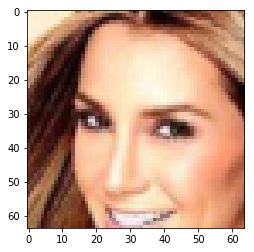

In [4]:
plt.imshow((sample[0] + 1.0)/2.0)
plt.show()

In [5]:
v = np.reshape(sample, (64, 64*64*3))
# number of features per image (pixels including all channels)
print('shape of v: {}'.format(v.shape))


n = v.shape[1]

shape of v: (64, 12288)


In [17]:
# this is compressed sensing setting
# m = 1000
# A = np.random.randn(n, m).astype('float32')
# A = A / np.sqrt( np.sum( A**2, axis = 1 ) )[:,None]
# y = np.dot(v, A) 

# this is full image included setting
m = n 
print('number of measurements = {}'.format(m))
y = v

number of measurements = 12288


In [7]:
# y_placeholder = tf.placeholder(tf.float32,[None,m])

# this loss is when we are doing compressed sensing
# our_loss = tf.reduce_mean( tf.reduce_sum( (tf.matmul(tf.reshape(dcgan.G, [64, -1]) , A) - y_placeholder)**2, 1)) 

# this loss is when we are taking image as measurement
# our_loss = tf.reduce_mean( tf.reduce_sum( (tf.reshape(dcgan.G, [64, -1]) - y_placeholder)**2, 1)) 

In [8]:
y.shape

(64, 12288)

In [9]:
#grad = tf.gradients(our_loss, dcgan.z)
#z_0 = np.random.uniform(-0.5, 0.5, size=(64 , 100))
count = 0

errs = []
    
    
with tf.Session() as sess:
    
    print(tf.global_variables())
    
    dcgan = DCGAN(
        sess,
        input_width=FLAGS.input_width,
        input_height=FLAGS.input_height,
        output_width=FLAGS.output_width,
        output_height=FLAGS.output_height,
        batch_size=FLAGS.batch_size,
        sample_num=FLAGS.batch_size,
        dataset_name=FLAGS.dataset,
        input_fname_pattern=FLAGS.input_fname_pattern,
        crop=FLAGS.crop,
        checkpoint_dir=FLAGS.checkpoint_dir,
        sample_dir=FLAGS.sample_dir)
    
    

    if not dcgan.load(FLAGS.checkpoint_dir)[0]:
        raise Exception("[!] Train a model first, then run test mode")
    
    dcgan.z.initializer.run()
    
    y_placeholder = tf.placeholder(tf.float32,[None,m])
    
    # -----------------------------------
    # use this if we are not using A
    our_loss = tf.reduce_mean( tf.reduce_sum( (tf.reshape(dcgan.G, [64, -1]) - y_placeholder)**2, 1)) 
    # use this if we are using A
#     our_loss = tf.reduce_mean( tf.reduce_sum( (tf.matmul(tf.reshape(dcgan.G, [64, -1]) , A) - y_placeholder)**2, 1)) 
    # -----------------------------------
    
    z_optim = tf.train.AdamOptimizer(learning_rate=0.1).minimize(our_loss, var_list=dcgan.z)  
    
#     show_all_variables()
    
    
    opt_initializers   = [var.initializer for var in tf.global_variables() if 'Adam' in var.name]
    beta1_initializers = [var.initializer for var in tf.global_variables() if 'beta1_power' in var.name]
    beta2_initializers = [var.initializer for var in tf.global_variables() if 'beta2_power' in var.name]
    
    sess.run(opt_initializers)
    sess.run(beta1_initializers)
    sess.run(beta2_initializers)

    
    for i in range(500): # run until error stops decreasing or reaches threshhold, then print result at that point
        print('iteration {}'.format(count))
        a, closs, b = sess.run([z_optim, our_loss, dcgan.G],feed_dict={y_placeholder: y})
        count += 1
        print(closs)
        errs.append(closs)
        #z_0 = z_0 - rate*a[0]
    

[]
 [*] Reading checkpoints...
Instructions for updating:
Please use tf.global_variables instead.
z:0
generator/g_h0_lin/Matrix:0
generator/g_h0_lin/bias:0
generator/g_bn0/beta:0
generator/g_bn0/gamma:0
generator/g_bn0/moving_mean:0
generator/g_bn0/moving_variance:0
generator/g_h1/w:0
generator/g_h1/biases:0
generator/g_bn1/beta:0
generator/g_bn1/gamma:0
generator/g_bn1/moving_mean:0
generator/g_bn1/moving_variance:0
generator/g_h2/w:0
generator/g_h2/biases:0
generator/g_bn2/beta:0
generator/g_bn2/gamma:0
generator/g_bn2/moving_mean:0
generator/g_bn2/moving_variance:0
generator/g_h3/w:0
generator/g_h3/biases:0
generator/g_bn3/beta:0
generator/g_bn3/gamma:0
generator/g_bn3/moving_mean:0
generator/g_bn3/moving_variance:0
generator/g_h4/w:0
generator/g_h4/biases:0
discriminator/d_h0_conv/w:0
discriminator/d_h0_conv/biases:0
discriminator/d_h1_conv/w:0
discriminator/d_h1_conv/biases:0
discriminator/d_bn1/beta:0
discriminator/d_bn1/gamma:0
discriminator/d_bn1/moving_mean:0
discriminator/d_b

369.733
iteration 291
369.812
iteration 292
369.021
iteration 293
368.777
iteration 294
367.596
iteration 295
368.471
iteration 296
368.04
iteration 297
367.063
iteration 298
366.496
iteration 299
366.134
iteration 300
365.719
iteration 301
365.802
iteration 302
364.471
iteration 303
364.385
iteration 304
363.896
iteration 305
363.816
iteration 306
362.942
iteration 307
363.185
iteration 308
362.331
iteration 309
362.596
iteration 310
361.949
iteration 311
361.536
iteration 312
360.979
iteration 313
360.651
iteration 314
360.27
iteration 315
360.063
iteration 316
359.729
iteration 317
359.128
iteration 318
358.959
iteration 319
358.825
iteration 320
358.593
iteration 321
358.025
iteration 322
357.714
iteration 323
357.402
iteration 324
357.154
iteration 325
357.015
iteration 326
356.933
iteration 327
356.78
iteration 328
356.631
iteration 329
355.668
iteration 330
355.521
iteration 331
355.734
iteration 332
354.914
iteration 333
355.003
iteration 334
354.63
iteration 335
353.957
iterat

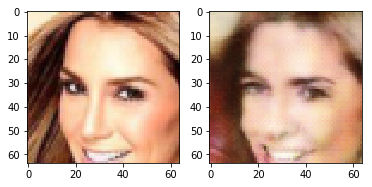

In [16]:
chosen_image = 0

fig = plt.figure()

ax1 = fig.add_subplot(121)
ax1.imshow((sample[chosen_image]+1.0)/2)

ax2 = fig.add_subplot(122)
ax2.imshow((b[chosen_image]+1.0)/2)

plt.show()